<a href="https://colab.research.google.com/github/FlyOrBoom/ulab-cosmo/blob/main/Halo_rasterization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import h5py
import numpy as np

%matplotlib inline

In [3]:
!pip install cupy-cuda12x

In [4]:
import cupy as cp

In [1]:
use2D = True

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
files = [
    h5py.File(f'/content/drive/MyDrive/ulab_data/halos/fof_subhalo_tab_099.{i}.hdf5', 'r')
    for i in range(128)
]

In [8]:
## Indices for halo data arrays
X, Y, Z, M, R = 0, 1, 2, 3, 4

## Halo data arrays (pre-merging)
halos_pre = [ list() for _ in [X, Y, Z, M, R] ]

## Write halo data from files into arrays
for file in files:
  halos_file = file["Subhalo"]

  if(len(halos_file) == 0): continue

  pos = halos_file["SubhaloPos"]
  halos_pre[X].append(pos[:][:, 0])
  halos_pre[Y].append(pos[:][:, 1])
  halos_pre[Z].append(pos[:][:, 2])

  halos_pre[M].append(halos_file["SubhaloMass"][:])
  halos_pre[R].append(halos_file["SubhaloHalfmassRad"][:])


In [9]:
## Concatenate attributes from multiple files (unfiltered)
halos_unfiltered = np.array([np.concatenate(attribute) for attribute in halos_pre])
halos_unfiltered

array([[7.2962998e+03, 6.8182197e+03, 8.0820508e+03, ..., 2.7774814e+04,
        3.3726809e+04, 3.2123824e+04],
       [2.4573279e+04, 2.3923941e+04, 2.4393629e+04, ..., 6.9553164e+03,
        9.4946641e+03, 2.2652363e+04],
       [2.1314562e+04, 2.1154814e+04, 2.0868680e+04, ..., 3.3994148e+03,
        1.8210898e+04, 3.8773127e+03],
       [1.3939052e+04, 1.6819067e+02, 2.9759535e+01, ..., 1.0577913e-03,
        1.1672180e-03, 1.1672180e-03],
       [4.0016257e+02, 6.4427376e+01, 4.3177193e+01, ..., 9.6932709e-01,
        1.4540626e+00, 1.3756530e+00]], dtype=float32)

In [10]:
## Filter halos (halos_unfiltered -> halos)
mass_cutoff = 1e2
halos = cp.array([ np.extract(halos_unfiltered[M] > mass_cutoff, attribute) for attribute in halos_unfiltered])
np.min(halos_unfiltered[M]), cp.min(halos[M])

(0.0007295112, array(100.3234, dtype=float32))

In [11]:
res = 1400
size = cp.max(halos[X])
scale = res/size

In [13]:
# Inverse square law

kernel_inv = cp.ElementwiseKernel(
    """T rx, T ry, T rz,
    T hx, T hy, T hz, T mass, T radius
    """, # inputs
    "T rho", # output
    f"""
      T rz = 0.0;

      T dx = rx - hx;
      T dy = ry - hy;
      T dz = rz - hz;

      T dd = dx*dx + dy*dy + {0 if use2D else 1}*dz*dz;

      rho = 1e3 / dd;
    """, # kernel
    name="kernel_inv",
    reduce_dims=False
)

In [14]:
# Pseudo-nfw

kernel_cooper = cp.ElementwiseKernel(
    """T rx, T ry, T rz,
    T hx, T hy, T hz, T mass, T radius
    """, # inputs
    "T rho", # output
    f"""
      T rz = 0.0;

      T dx = rx - hx;
      T dy = ry - hy;
      T dz = rz - hz;

      T dd = dx*dx + dy*dy + {0 if use2D else 1}*dz*dz;

      T d = sqrt(dd);

      T r = d/radius;

      T rho0 = mass / radius*radius*radius;

      rho = 1e3 / (r*(1 + r)*(1 + r));
    """,
    name="kernel_inv",
    reduce_dims=False
)

In [15]:
scale_radius = 1e8

kernel_nfw = cp.ElementwiseKernel(
    """T rx, T ry, T rz,
    T hx, T hy, T hz, T mass, T radius
    """, # inputs
    "T rho", # output
    f"""
      T rz = 0.0;
      T scale_radius = { scale_radius };

      T dx = rx - hx;
      T dy = ry - hy;
      T dz = rz - hz;

      T dd = dx*dx + dy*dy + {0 if use2D else 1}*dz*dz;
      T d = sqrt(dd);

      T a = (4/3) * 3.14159;

      T mean_rho = mass / (a * radius*radius*radius);

      T rR = d / scale_radius;

      rho = mean_rho / ( rR * (1+rR) * (1+rR) );
    """,
    name="kernel_nfw",
    reduce_dims=False
)

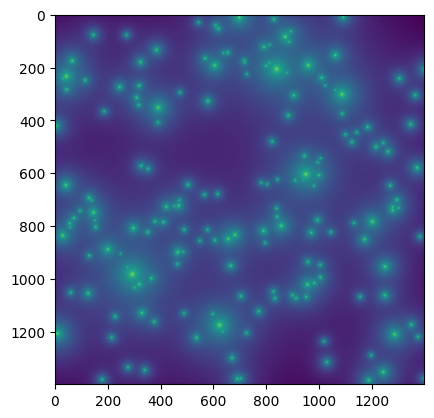

In [34]:
halos_raster = cp.zeros( (res, res), dtype=float)

for halo in cp.transpose(halos):
  hx = halo[X]
  hy = halo[Y]
  hz = halo[Z]

  radius = halo[R]
  mass = halo[M]

  ## Create res x res coordinate grid
  lin = cp.linspace(0, size, res)
  if use2D:
    xx, yy = cp.meshgrid(lin, lin)
    zz = 0
  else:
    xx, yy, zz = cp.meshgrid(lin, lin, lin)

  ## Run rasterization code on coordinate grid with the parameters of a halo
  # halos_raster += kernel_nfw(xx, yy, hx, hy, hz, mass, radius)
  halos_raster += kernel_cooper(xx, yy, zz, hx, hy, hz, mass, radius)

img = halos_raster.get()

plt.figure(dpi = 100)
plt.imshow(np.log(img))

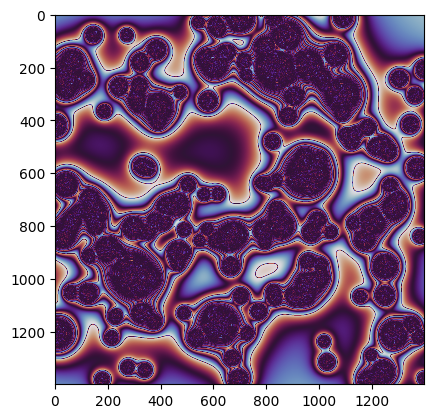

In [32]:
plt.imshow(np.mod(img, np.max(img)*1e-5), cmap='twilight')

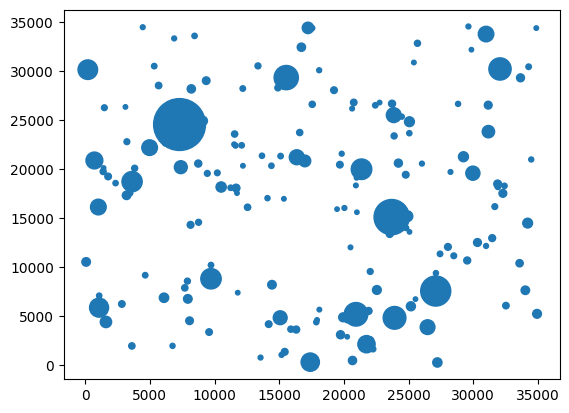

In [ ]:
plt.scatter(halos[X].get(), halos[Y].get(), s=halos[M].get()*0.1)

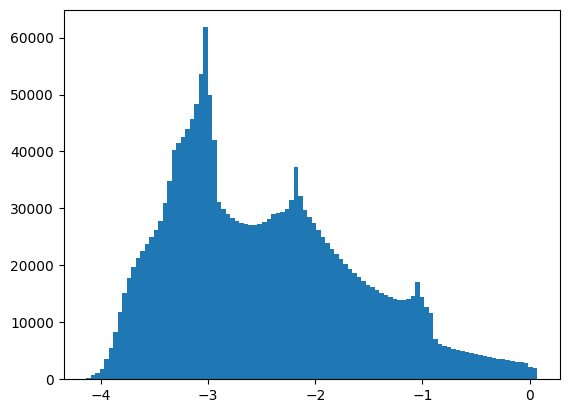

In [ ]:
n, bins, patches = plt.hist(np.log(img.flatten()), bins=100)
plt.show()